In [1]:
import numpy as np 
import pandas as pd 
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
plt.rcParams['figure.dpi'] = 100 

!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

<p style="font-family:Times New Roman; font-weight:normal; letter-spacing: 2px; color:#454545; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid #454545">Introduction</p>

<div style="font-family:Times New Roman">
<p>In this project, we aim to analyse a dataset obtained from the Global School-Based Student Health Survey (GSHS) using association rule mining to discover patterns and relationships within the data that can help explain the story of bullying. The GSHS is a school-based survey that utilises self-administered questionnaires to collect information on the health behaviors and protective factors among young people, which are related to the leading causes of morbidity and mortality. The survey was conducted in Argentina in 2018, with a total of 56,981 students participating.</p>

<p>The dataset consists of the following selected variables:</p>

<ul>
    <li>Bullied on school property in past 12 months</li>
    <li>Bullied not on school property in past 12 months</li>
    <li>Cyber bullied in past 12 months</li>
    <li>Custom Age</li>
    <li>Sex</li>
    <li>Physically attacked</li>
    <li>Physical fighting</li>
    <li>Felt lonely</li>
    <li>Close friends</li>
    <li>Miss school no permission</li>
    <li>Other students kind and helpful</li>
    <li>Parents understand problems</li>
    <li>Most of the time or always felt lonely</li>
    <li>Missed classes or school without permission</li>
</ul>
    
<p>Our plan is to preprocess the data into boolean features, which can then be used to conduct association rule mining analysis. This will enable us to identify interesting and potentially significant associations between the variables, helping us better understand the complex dynamics of bullying and other related factors. By uncovering these relationships, we hope to gain valuable insights that can contribute to the development of effective strategies and interventions to address bullying and promote a safer and more inclusive school environment for all students.</p>
</div>

<p style="font-family:Times New Roman; font-weight:normal; letter-spacing: 2px; color:#454545; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid #454545">Data pre-processing</p>

<div style="font-family:Times New Roman">
    <p>Here are the steps we're taking to prepare our data for association mining:</p>
    <ol>
        <li>Load the data into a Pandas dataframe and replace any blank spaces with NaN values to ensure consistency.</li>
        <li>Define a custom function called "to_bool" that converts specific column values to "True", "False", and "Missing".</li>
        <li>Apply the "to_bool" function to select columns that we're interested in.</li>
        <li>Drop any unnecessary columns that won't be useful for our association mining.</li>
        <li>Extract the age data from the "Custom_Age" column and drop any missing values from our dataset.</li>
        <li>Create new boolean columns for specific conditions like whether someone is a teen, male, or female, or if they've been physically attacked or involved in physical fighting.</li>
        <li>Create integer columns to represent how often they've felt lonely or how many close friends they have.</li>
        <li>Create boolean columns for each category of "Miss_school_no_permission" and "Other_students_kind_and_helpful".</li>
        <li>Drop any unwanted columns from the dataset.</li>
    </ol>
    <p>By performing these data processing steps, we're ensuring that our data is in a suitable format for association mining rules to help us identify any interesting or unexpected correlations between different attributes in our dataset.</p>
</div>

In [2]:
data = pd.read_csv("/kaggle/input/bullying-in-schools/Bullying_2018.csv",sep=';')
data.replace(' ', np.nan, inplace=True)

# Function to convert 'Yes', 'No', and empty string values to 'True', 'False', and 'Missing', respectively
def to_bool(data, col):
    data[col] = data[col].map({'Yes': True, 'No': False})
    return data[col]

# Apply the 'to_bool' function to specified columns
for col in ['Bullied_on_school_property_in_past_12_months','Bullied_not_on_school_property_in_past_12_months',
            'Cyber_bullied_in_past_12_months','Most_of_the_time_or_always_felt_lonely','Missed_classes_or_school_without_permission']:
    data[col] = to_bool(data, col)

# Drop unnecessary columns
data.drop(columns=['Were_underweight','Were_overweight','Were_obese'], axis=1, inplace=True)

# Extract the first part of the 'Custom_Age' column and drop missing values
data.Custom_Age = data.Custom_Age.str.split(expand=True)[0]
data = data.dropna()

# Create new boolean columns for different conditions
data['is_teen'] = data['Custom_Age'].apply(lambda x: True if int(x) > 13 else False)
data['is_male'] = data['Sex'].apply(lambda x: True if x == 'Male' else False)
data['is_female'] = data['Sex'].apply(lambda x: True if x == 'Female' else False)

# Create boolean columns for each 'Physically_attacked' category
data['attacked_0_times'] = data['Physically_attacked'].apply(lambda x: True if x == '0 times' else False)
data['attacked_1_time'] = data['Physically_attacked'].apply(lambda x: True if x == '1 time' else False)
data['attacked_2_or_3_times'] = data['Physically_attacked'].apply(lambda x: True if x == '2 or 3 times' else False)
data['attacked_4_or_5_times'] = data['Physically_attacked'].apply(lambda x: True if x == '4 or 5 times' else False)
data['attacked_6_or_7_times'] = data['Physically_attacked'].apply(lambda x: True if x == '6 or 7 times' else False)
data['attacked_8_or_9_times'] = data['Physically_attacked'].apply(lambda x: True if x == '8 or 9 times' else False)
data['attacked_10_or_11_times'] = data['Physically_attacked'].apply(lambda x: True if x == '10 or 11 times' else False)
data['attacked_12_or_more_times'] = data['Physically_attacked'].apply(lambda x: True if x == '12 or more times' else False)

# Create boolean columns for each 'Physical_fighting' category
data['fought_0_times'] = data['Physical_fighting'].apply(lambda x: True if x == '0 times' else False)
data['fought_1_time'] = data['Physical_fighting'].apply(lambda x: True if x == '1 time' else False)
data['fought_2_or_3_times'] = data['Physical_fighting'].apply(lambda x: True if x == '2 or 3 times' else False)
data['fought_4_or_5_times'] = data['Physical_fighting'].apply(lambda x: True if x == '4 or 5 times' else False)
data['fought_6_or_7_times'] = data['Physical_fighting'].apply(lambda x: True if x == '6 or 7 times' else False)
data['fought_8_or_9_times'] = data['Physical_fighting'].apply(lambda x: True if x == '8 or 9 times' else False)
data['fought_10_or_11_times'] = data['Physical_fighting'].apply(lambda x: True if x == '10 or 11 times' else False)
data['fought_12_or_more_times'] = data['Physical_fighting'].apply(lambda x: True if x == '12 or more times' else False)

# Create integer columns for each 'Felt_lonely' category
data['Felt_lonely_Never'] = (data['Felt_lonely'] == 'Never').astype('bool')
data['Felt_lonely_Sometimes'] = (data['Felt_lonely'] == 'Sometimes').astype('bool')
data['Felt_lonely_Rarely'] = (data['Felt_lonely'] == 'Rarely').astype('bool')
data['Felt_lonely_Most_of_the_time'] = (data['Felt_lonely'] == 'Most of the time').astype('bool')
data['Felt_lonely_Always'] = (data['Felt_lonely'] == 'Always').astype('bool')

# Create integer columns for each 'Close_friends' category
data['close_friends_0'] = (data['Close_friends'] == 0).astype('bool')
data['close_friends_1'] = (data['Close_friends'] == 1).astype('bool')
data['close_friends_2'] = (data['Close_friends'] == 2).astype('bool')
data['close_friends_3_or_more'] = (data['Close_friends'] == '3 or more').astype('bool')

# Create boolean columns for each 'Miss_school_no_permission' category
data['Missed_school_0_days'] = (data['Miss_school_no_permission'] == '0 days')
data['Missed_school_1_2_days'] = (data['Miss_school_no_permission'] == '1 or 2 days')
data['Missed_school_3_5_days'] = (data['Miss_school_no_permission'] == '3 to 5 days')
data['Missed_school_6_9_days'] = (data['Miss_school_no_permission'] == '6 to 9 days')
data['Missed_school_10_or_more_days'] = (data['Miss_school_no_permission'] == '10 or more days')

# Create integer columns for each 'Other_students_kind_and_helpful' category
data['Students_kind_and_helpful_most_of_the_time'] = (data['Other_students_kind_and_helpful'] == 'Most of the time').astype('bool')
data['Students_kind_and_helpful_sometimes'] = (data['Other_students_kind_and_helpful'] == 'Sometimes').astype('bool')
data['Students_kind_and_helpful_rarely'] = (data['Other_students_kind_and_helpful'] == 'Rarely').astype('bool')
data['Students_kind_and_helpful_always'] = (data['Other_students_kind_and_helpful'] == 'Always').astype('bool')
data['Students_kind_and_helpful_never'] = (data['Other_students_kind_and_helpful'] == 'Never').astype('bool')

# Dropping unwanted columns
data.drop(columns=['record','Custom_Age','Sex','Physically_attacked','Physical_fighting','Felt_lonely','Close_friends',
                  'Other_students_kind_and_helpful','Miss_school_no_permission','Parents_understand_problems'],inplace=True)

<p style="font-family:Times New Roman; font-weight:normal; letter-spacing: 2px; color:#454545; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid #454545">Finding rules using the Apriori algorithm</p>


<div style="font-family: 'Times New Roman', Times, serif;">
<p>The Apriori algorithm is a method of identifying frequent item sets and association rules from a transactional database. It is based on the principle that if an itemset is frequent, then all of its subsets must also be frequent. The algorithm is named Apriori because it uses prior knowledge of frequent item sets to efficiently generate new item sets and association rules.</p>
<p>The algorithm works as follows:</p>
<ol>
  <li>We start by creating a set of unique items from our data columns. We then apply set operations to identify frequent item sets, with the minimum support threshold set to 0.1. For each column, we calculate the support sup(X), which is the proportion of transactions that contain the item X. If the support is greater than or equal to the minimum threshold, we add the item to the item_sets list.</li>
  <li>We define two functions: calc_support and calc_confidence. The calc_support function calculates the support for a given item set X, which is the proportion of transactions that contain all the items in the set. We can calculate it as follows:</li>
   <br>
  <p style="text-indent: 20px;">$sup(X) = \frac{\text{number of transactions containing X}}{\text{total number of transactions}}$</p>
  <p>The calc_confidence function calculates the confidence for an association rule X → Y, which is the proportion of transactions containing both the item set X and additional item Y, divided by the proportion of transactions containing only the item set X. We can calculate it as follows:</p>
  <p style="text-indent: 20px;">$conf(X \rightarrow Y) = \frac{sup(X \cup Y)}{sup(X)}$</p>
  <li>We generate all possible association rules by iterating through each item set and comparing it to every other item set. We then calculate the support and confidence for each association rule, and if the confidence is greater than 0, we add it to the results list.</li>
  <li>The results list contains the label, support, and confidence for each association rule, which we can use to identify interesting and meaningful relationships between different attributes in our dataset.</li>
</ol>
<p>We can use this algorithm to identify frequent item sets and association rules in our dataset, which can help us understand the relationships between different attributes and make more informed decisions.</p>
<p>Reference: Witten, I. H., &amp; Frank, E. (2005). <i>Data Mining: Practical Machine Learning Tools and Techniques.</i> Morgan Kaufmann Series in Data Management Systems.</p>
</div>

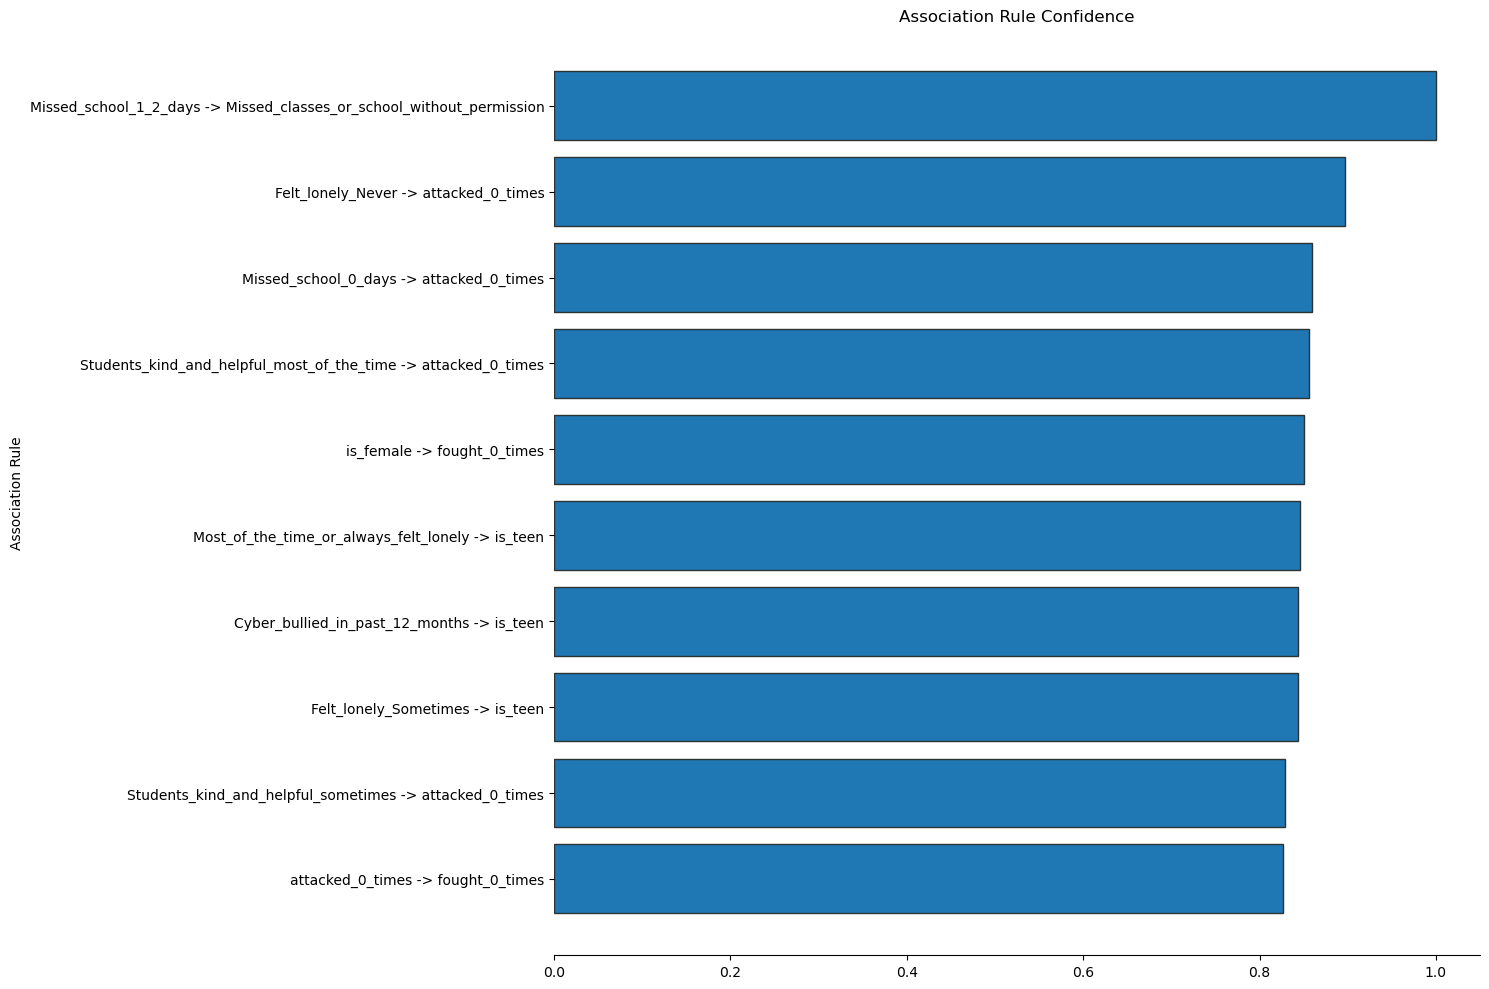

In [3]:
# Create set of unique items
items = set(data.columns)

# Apply set operations to identify frequent item sets
min_support = 0.1  # Minimum support threshold
item_sets = []
for col in items:
    support = len(data[data[col] == True]) / len(data)
    if support >= min_support:
        item_sets.append({col})

# Define function to calculate support and confidence
def calc_support(item_set):
    return len(data[data[list(item_set)].all(axis=1)]) / len(data)

def calc_confidence(item_set, additional_item):
    item_support = calc_support(item_set)
    combined_support = len(data[data[list(item_set.union(additional_item))].all(axis=1)]) / len(data)
    return combined_support / item_support

# Generate all possible association rules
association_rules = []
for i in range(len(item_sets)):
    for j in range(i+1, len(item_sets)):
        item_set = item_sets[i]
        additional_item = item_sets[j] - item_set
        if additional_item:
            association_rules.append({"items": item_set, "additional_item": additional_item})

# Calculate support and confidence for each association rule
results = []
for rule in association_rules:
    item_set = rule["items"]
    additional_item = rule["additional_item"]
    support = calc_support(item_set)
    confidence = calc_confidence(item_set, additional_item)
    if confidence > 0:
        results.append({"label": f"{', '.join(item_set)} -> {', '.join(additional_item)}", "support": support, "confidence": confidence})

# Sort the association rules by confidence in ascending order
results = sorted(results, key=lambda x: x["confidence"], reverse=True)
results = results[:10]

fig, ax = plt.subplots(figsize=(15, 10))
ax.barh([r["label"] for r in results], [r["confidence"] for r in results], edgecolor='#2C3333')

ax.set_title("Association Rule Confidence")
ax.set_xlabel("")
ax.set_ylabel("Association Rule")
ax.tick_params(axis="y")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

<div style="font-family: 'Times New Roman'">
<p>The findings presented offer fascinating insights into the relationships between various factors related to bullying and students' experiences. Let's delve deeper into each of the identified patterns and analyse their implications using Australian English.


<ul>
    <li>There is a strong link between students missing school for 1-2 days and missing classes or school without permission. This association may suggest that students who are wagging classes could be doing so to avoid bullying or other negative experiences at school.</li>
    <li>Students who never feel lonely are predominantly not attacked. This correlation might imply that having a strong social support network or feeling connected to others could serve as a protective factor against bullying.</li>
    <li>A high percentage of students who missed no school days were also not attacked. This connection could indicate that students who are more regularly present at school might be at a lower risk of experiencing bullying.</li>
    <li>Students who perceive their peers as kind and helpful most of the time are less likely to be attacked. This finding underscores the importance of fostering a positive and supportive school environment to reduce bullying incidents.</li>
    <li>Female students are more likely to have not engaged in physical fights. This result might reflect gender differences in aggressive behaviours and suggests that interventions may need to be tailored to address specific gender-related issues.</li>
    <li>Students who feel lonely most of the time or always are more likely to be teenagers. This correlation highlights the potential vulnerability of teenagers to social isolation and the need to provide additional support during this challenging developmental period.</li>
    <li>Cyberbullying in the past 12 months is more prevalent among teenagers. This finding reinforces the importance of addressing cyberbullying specifically within this age group and implementing strategies to protect teenagers online.</li>
    <li>Teenagers are more likely to feel lonely sometimes. This result underlines the need for interventions that focus on promoting social connectedness and positive relationships among teenagers.</li>
    <li>Students who perceive their peers as kind and helpful sometimes are less likely to be attacked. This finding further emphasises the role of a supportive school environment in reducing bullying incidents.</li>
    <li>Students who are not attacked are more likely not to have engaged in physical fights. This association suggests that experiencing bullying could be a risk factor for engaging in aggressive behaviour and highlights the potential cyclical nature of bullying.</li>
</ul>
</div>

<p style="font-family:Times New Roman; font-weight:normal; letter-spacing: 2px; color:#454545; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid #454545">Can the dataset we have successfully predict one of the following outcomes?</p>

<div style="font-family: 'Times New Roman', serif;">
<p>We will use the XGBoost classifier to build our predictive model and evaluate its performance. To test the accuracy of our model, we will employ a holdout set, a portion of the data that will be set aside and used exclusively for testing purposes. This approach will help us determine whether our model can make accurate predictions for the given outcomes.</p>
<p>The two outcomes we will be predicting are:</p>
<ol>
<li>Bullied on school property in the past 12 months</li>
<li>Cyberbullied in the past 12 months</li>
</ol>
<p>Using XGBoost, we can train a model on a training set of data that includes information on past bullying experiences and other relevant factors. We can then use this model to make predictions on the holdout set, and compare the predicted outcomes to the actual outcomes to evaluate the accuracy of our model.</p>
</div>

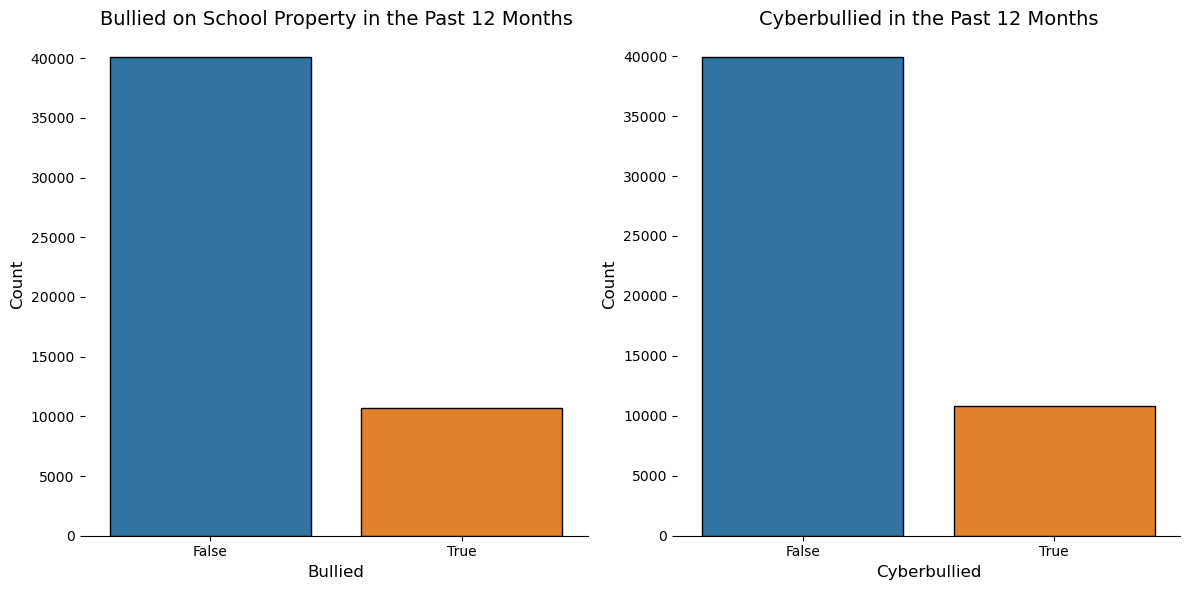

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(ax=axes[0], data=data, x='Bullied_on_school_property_in_past_12_months', edgecolor='black')
axes[0].set_title('Bullied on School Property in the Past 12 Months', fontname='Times New Roman', fontsize=14)
axes[0].set_xlabel('Bullied', fontname='Times New Roman', fontsize=12)
axes[0].set_ylabel('Count', fontname='Times New Roman', fontsize=12)
axes[0].tick_params(axis='both', labelsize=10)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['left'].set_visible(False)

sns.countplot(ax=axes[1], data=data, x='Cyber_bullied_in_past_12_months', edgecolor='black')
axes[1].set_title('Cyberbullied in the Past 12 Months', fontname='Times New Roman', fontsize=14)
axes[1].set_xlabel('Cyberbullied', fontname='Times New Roman', fontsize=12)
axes[1].set_ylabel('Count', fontname='Times New Roman', fontsize=12)
axes[1].tick_params(axis='both', labelsize=10)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

<div style="font-family: times new roman">
<p>We can observe that both of our target variables are imbalanced. Consequently, employing the Synthetic Minority Over-sampling Technique (SMOTE) would be beneficial in improving our model's accuracy when predicting outcomes on the holdout set. Before implementing SMOTE, we must first divide our dataset into a training set and a holdout set. To do this, I will create separate copies of the data, one for <code>'Bullied_on_school_property_in_past_12_months'</code> and another for <code>'Cyber_bullied_in_past_12_months'</code> so we can test them independently.</p>
</div>

<p style="font-family:Times New Roman; font-weight:normal; letter-spacing: 2px; color:#454545; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid #454545">Synthetic Minority Over-sampling Technique (SMOTE)</p>

In [5]:
# Create separate copies of the data for each target variable
data_bullied_on_school_property = data.drop(columns=['Bullied_not_on_school_property_in_past_12_months','Cyber_bullied_in_past_12_months']).copy()
data_cyber_bullied = data.drop(columns=['Bullied_not_on_school_property_in_past_12_months','Bullied_on_school_property_in_past_12_months']).copy()

# Define X and y for each target
X_bullied_on_school_property = data_bullied_on_school_property.drop('Bullied_on_school_property_in_past_12_months', axis=1)
y_bullied_on_school_property = data_bullied_on_school_property['Bullied_on_school_property_in_past_12_months']

X_cyber_bullied = data_cyber_bullied.drop('Cyber_bullied_in_past_12_months', axis=1)
y_cyber_bullied = data_cyber_bullied['Cyber_bullied_in_past_12_months']

# Convert boolean target variables to integer format
X_bullied_on_school_property = X_bullied_on_school_property.astype(int)
X_cyber_bullied = X_cyber_bullied.astype(int)

y_bullied_on_school_property = y_bullied_on_school_property.astype(int)
y_cyber_bullied = y_cyber_bullied.astype(int)

# Split the dataset into training and holdout sets
X_train_bullied_on_school_property, X_holdout_bullied_on_school_property, y_train_bullied_on_school_property, y_holdout_bullied_on_school_property = train_test_split(
    X_bullied_on_school_property, y_bullied_on_school_property, test_size=0.3, random_state=42)

X_train_cyber_bullied, X_holdout_cyber_bullied, y_train_cyber_bullied, y_holdout_cyber_bullied = train_test_split(
    X_cyber_bullied, y_cyber_bullied, test_size=0.3, random_state=42)

<div style="font-family: times new roman;">
We are preparing the data for building predictive models for two target variables: "Bullied on school property in the past 12 months" and "Cyberbullied in the past 12 months". We first create separate copies of the data for each target variable by dropping the other two target variables. We define X (features) and y (target) for each target variable. The boolean target variables are converted to integer format.

We then split each dataset into a training set and a holdout set using the train_test_split function from scikit-learn. The training set will be used to train the model, while the holdout set will be used to evaluate the performance of the model. The split is done with a test size of 0.3 and a random state of 42 to ensure reproducibility of the results.

</div>

In [6]:
# Initialise SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to 'Bullied_on_school_property_in_past_12_months' dataset
X_train_bullied_on_school_property, y_train_bullied_on_school_property = smote.fit_resample(
    X_train_bullied_on_school_property, y_train_bullied_on_school_property)

# Apply SMOTE to 'Cyber_bullied_in_past_12_months' dataset
X_train_cyber_bullied, y_train_cyber_bullied = smote.fit_resample(
    X_train_cyber_bullied, y_train_cyber_bullied)

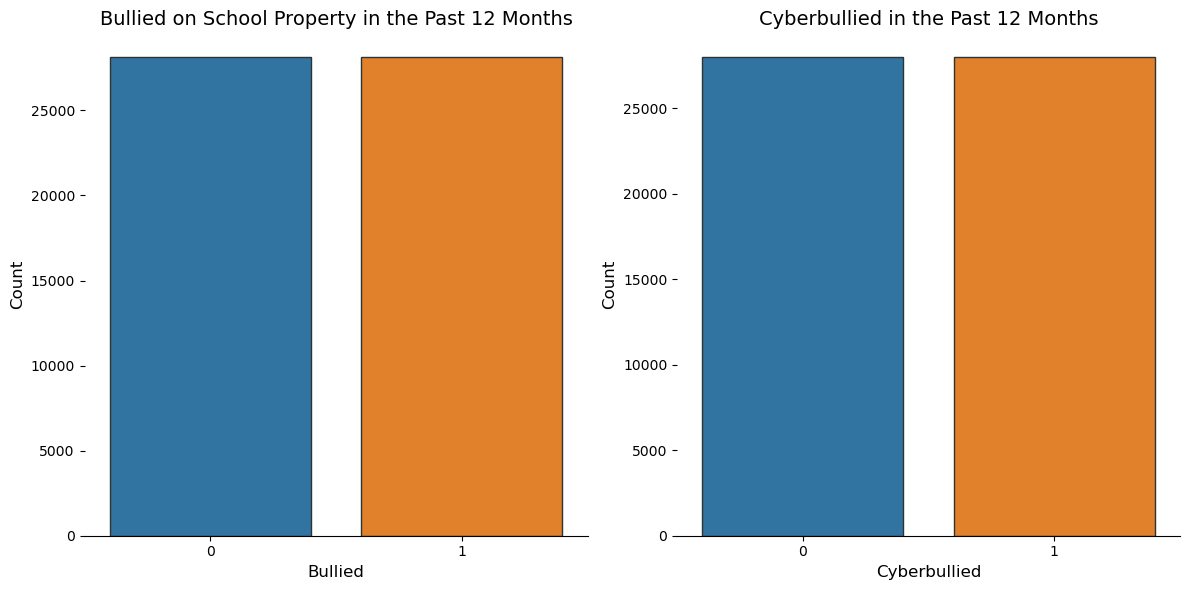

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(ax=axes[0], x=y_train_bullied_on_school_property, edgecolor='#2C3333')
axes[0].set_title('Bullied on School Property in the Past 12 Months', fontname='Times New Roman', fontsize=14)
axes[0].set_xlabel('Bullied', fontname='Times New Roman', fontsize=12)
axes[0].set_ylabel('Count', fontname='Times New Roman', fontsize=12)
axes[0].tick_params(axis='both', labelsize=10)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['left'].set_visible(False)

sns.countplot(ax=axes[1], x=y_train_cyber_bullied, edgecolor='#2C3333')
axes[1].set_title('Cyberbullied in the Past 12 Months', fontname='Times New Roman', fontsize=14)
axes[1].set_xlabel('Cyberbullied', fontname='Times New Roman', fontsize=12)
axes[1].set_ylabel('Count', fontname='Times New Roman', fontsize=12)
axes[1].tick_params(axis='both', labelsize=10)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

<p style="font-family:Times New Roman; font-weight:normal; letter-spacing: 2px; color:#454545; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid #454545">Feature Importance (XGBClassifier)</p>

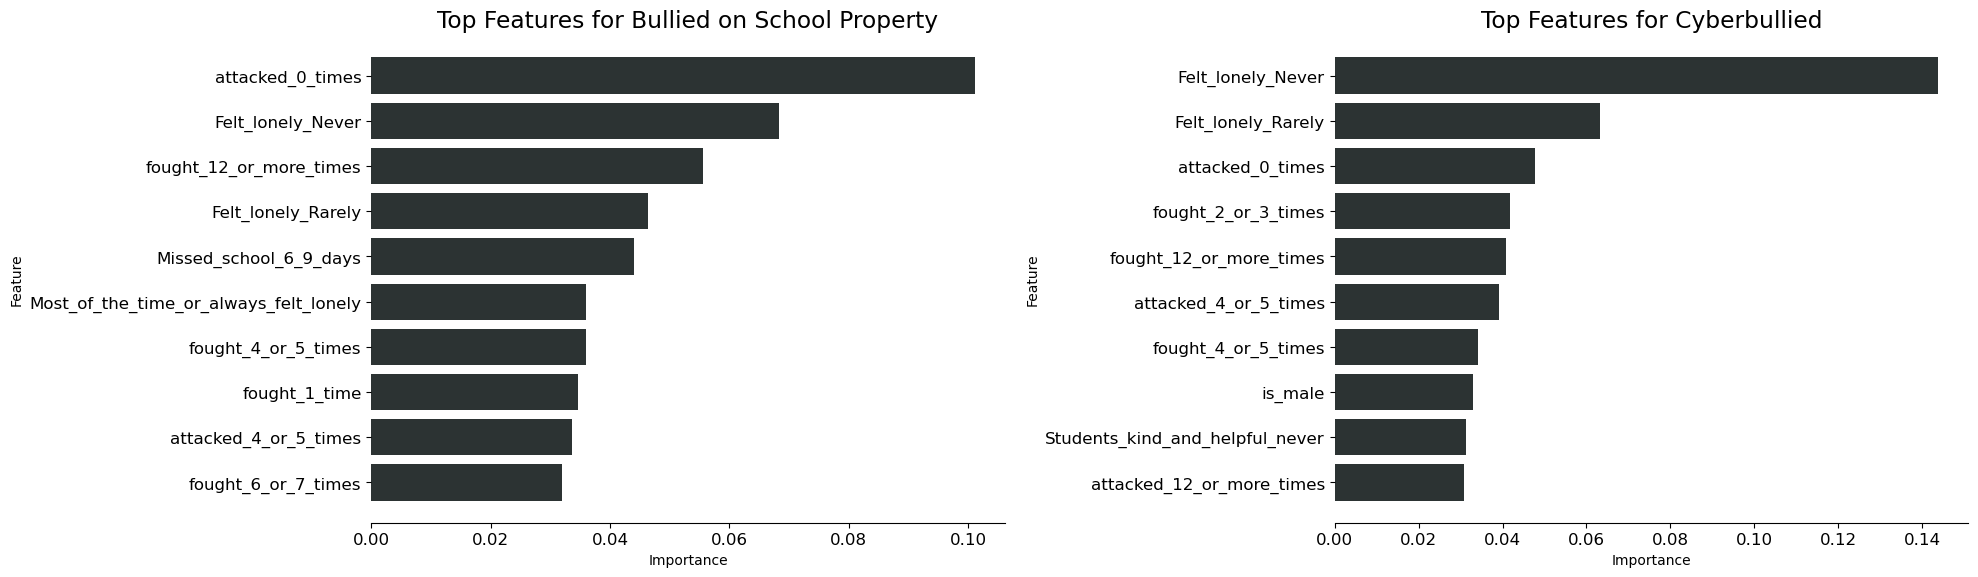

In [8]:
def plot_top_features_subplot(X_train1, y_train1, X_train2, y_train2, num_features=10):
    # Fit the first model
    model1 = xgb.XGBClassifier(n_estimators=200, tree_method='gpu_hist', random_state=42)
    model1.fit(X_train1, y_train1)
    
    # Extract feature importances and sort them by importance for the first model
    feature_importances1 = model1.feature_importances_
    sorted_idx1 = feature_importances1.argsort()[-num_features:]
    
    # Create a DataFrame with feature names and their importances for the first model
    top_features1 = pd.DataFrame({"Feature": X_train1.columns[sorted_idx1],
                                  "Importance": feature_importances1[sorted_idx1]})
    
    # Sort the top features by importance for the first model
    top_features1.sort_values(by="Importance", ascending=True, inplace=True)
    
    # Fit the second model
    model2 = xgb.XGBClassifier(n_estimators=200, tree_method='gpu_hist', random_state=42)
    model2.fit(X_train2, y_train2)
    
    # Extract feature importances and sort them by importance for the second model
    feature_importances2 = model2.feature_importances_
    sorted_idx2 = feature_importances2.argsort()[-num_features:]
    
    # Create a DataFrame with feature names and their importances for the second model
    top_features2 = pd.DataFrame({"Feature": X_train2.columns[sorted_idx2],
                                  "Importance": feature_importances2[sorted_idx2]})
    
    # Sort the top features by importance for the second model
    top_features2.sort_values(by="Importance", ascending=True, inplace=True)
    
    # Plot the feature importances for both models
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    # Set font for titles, labels, and ticks
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 14
    
    # Set color for bars
    bar_color = '#2C3333'
    
    # Plot the first subplot
    axes[0].barh(top_features1["Feature"], top_features1["Importance"], color=bar_color)
    axes[0].set_title("Top Features for Bullied on School Property")
    axes[0].set_xlabel("Importance")
    axes[0].set_ylabel("Feature")
    axes[0].tick_params(axis='both', labelsize=12)
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['left'].set_visible(False)
    
    # Plot the second subplot
    axes[1].barh(top_features2["Feature"], top_features2["Importance"], color=bar_color)
    axes[1].set_title("Top Features for Cyberbullied")
    axes[1].set_xlabel("Importance")
    axes[1].set_ylabel("Feature")
    axes[1].tick_params(axis='both', labelsize=12)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['left'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_top_features_subplot(X_train_bullied_on_school_property, y_train_bullied_on_school_property, X_train_cyber_bullied, y_train_cyber_bullied)

<div style="font-family: times new roman;">
<p>It is surprising that the features that are least expected to be crucial in predicting being bullied, such as <code>attacked_0_times</code> and <code>Felt_lonley_Never</code>, are actually the most significant. This is because valuable information is often hidden in unexpected places, just like how treasure can be found in unlikely spots. The complexity of bullying as an issue means that seemingly unimportant variables could be essential in comprehending and predicting it. Solving the puzzle of bullying requires thinking outside the box and approaching the problem from different perspectives, just like finding hidden treasure requires a unique approach.</p>
</div>

<p style="font-family:Times New Roman; font-weight:normal; letter-spacing: 2px; color:#454545; font-size:200%; text-align:left;padding: 0px; border-bottom: 3px solid #454545">Building the XGBClassifier</p>

<div style="font-family: 'Times New Roman', Times, serif;">
<p>Here we are developing two models to predict whether a student has been bullied on school property or cyberbullied. We are using a popular machine learning algorithm called XGBoost to make these predictions. To assess the performance of these models, we are utilising a metric called ROC AUC score. This metric helps us measure how well the model distinguishes between positive and negative cases, in this case whether a student has experienced bullying or not.</p>
    
<p>To prevent our models from overfitting the data, we are employing a technique called cross-validation. This involves splitting the data into multiple subsets, training the model on some of the subsets and then evaluating its performance on the remaining subsets. We repeat this process several times to obtain a more accurate estimate of the model's performance.</p>

<p>It's worth noting that we are not optimising our model's hyperparameters, which is something that can be done to ensure we have the best possible parameters for our model. Typically, it's best to test the model at baseline and then optimise it later. However, this is beyond the scope of this notebook. Ideally, we should have created a holdout set from the beginning and developed the most optimal model for this dataset.</p>
</div>

-------------- FOLD 10 ---------------
XGBClassifier (Bullied on school property): 0.7528

-------------- FOLD 20 ---------------
XGBClassifier (Bullied on school property): 0.7523

-------------- FOLD 10 ---------------
XGBClassifier (Cyber bullied): 0.7609

-------------- FOLD 20 ---------------
XGBClassifier (Cyber bullied): 0.7614



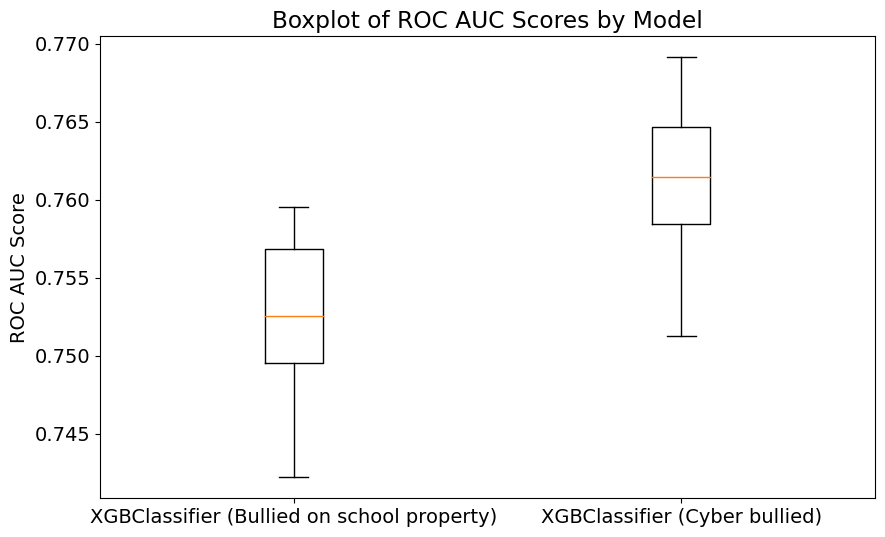

In [9]:
# Predict bullied on school property
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
X = X_train_bullied_on_school_property
y = y_train_bullied_on_school_property

probas_xgb_bullied = np.zeros(len(y))
scores_xgb_bullied = []

for fold, (train_index, test_index) in enumerate(rkf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    xgb_model = xgb.XGBClassifier(n_estimators=1000, tree_method='gpu_hist', random_state=42).fit(X_train, y_train)
    probas_xgb_bullied[test_index] = xgb_model.predict_proba(X_test)[:, 1]
    
    scores_xgb_bullied.append(roc_auc_score(y_test, probas_xgb_bullied[test_index]))
    
    if (fold + 1) % 10 == 0:
        print("-------------- FOLD {0} ---------------".format(fold+1))
        print("XGBClassifier (Bullied on school property): {0:.4f}".format(np.mean(scores_xgb_bullied)))
        print()  

# Predict cyber bullied
X = X_train_cyber_bullied
y = y_train_cyber_bullied

probas_xgb_cyber = np.zeros(len(y))
scores_xgb_cyber = []

for fold, (train_index, test_index) in enumerate(rkf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    xgb_model = xgb.XGBClassifier(n_estimators=1000, tree_method='gpu_hist', random_state=42).fit(X_train, y_train)
    probas_xgb_cyber[test_index] = xgb_model.predict_proba(X_test)[:, 1]
    
    scores_xgb_cyber.append(roc_auc_score(y_test, probas_xgb_cyber[test_index]))
    
    if (fold + 1) % 10 == 0:
        print("-------------- FOLD {0} ---------------".format(fold+1))
        print("XGBClassifier (Cyber bullied): {0:.4f}".format(np.mean(scores_xgb_cyber)))
        print()  

# Evaluate model performance using boxplot
model_scores = {'XGBClassifier (Bullied on school property)': scores_xgb_bullied,
                'XGBClassifier (Cyber bullied)': scores_xgb_cyber}

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(model_scores.values())
ax.set_xticklabels(model_scores.keys())
ax.set_ylabel('ROC AUC Score')
ax.set_title('Boxplot of ROC AUC Scores by Model')
plt.show()

<p style="font-family: 'Times New Roman'">Our analysis reveals that the models show a moderate level of predictive accuracy in identifying cases of bullying. The ROC AUC scores for both models fall between 0.74 and 0.77, indicating that they possess a reasonable capacity to differentiate between students who have experienced bullying and those who haven't. However, there is some variability in the scores across the cross-validation folds, suggesting that there is potential for enhancing the models' performance.</p>
<p style="font-family: 'Times New Roman'">It's crucial to recognise that the models were constructed without optimising their hyperparameters, which could have a substantial impact on their overall efficacy. Moreover, the models' performance is based on a specific dataset and may not be directly applicable to other contexts or datasets. As a result, it's essential to approach these findings with a critical mindset, and further optimisation and evaluation of the models should be carried out before deploying them in real-world scenarios.</p>

<p style="font-family: 'Times New Roman'">Mentions: @jcaliz and @sergeysaharovskiy for css and plotting ideas